<a href="https://colab.research.google.com/github/Lucs1590/vgg_bpca/blob/master/notebooks/vgg_bpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VGG_BPCA
Here we are using a VGG net with 19 layers with the dataset cifar 100.

We are trying to reproduce the results of the paper [1] changing the max pooling layers for blocked based principal component analysis (BPCA) layers like the article [2] proposes.

[1] https://arxiv.org/pdf/1706.05350.pdf

[2] http://www.ic.uff.br/iwssip2010/Proceedings/nav/papers/paper_10.pdf

[3] https://ieeexplore.ieee.org/document/5654484

## Imports

In [1]:
%pip install lime
import os
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar100
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import data_utils, layer_utils, to_categorical
from sklearn.model_selection import train_test_split
# from google.colab import drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=85aa05ff59c29d13a28db30390839bf0e3bbe821911dbb466911fd3e0804c0a3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
np.random.seed(77)
tf.random.set_seed(77)


In [3]:
classes_dict = {
    "0": ['apple'],
    "1": ['aquarium_fish'],
    "2": ['baby'],
    "3": ['bear'],
    "4": ['beaver'],
    "5": ['bed'],
    "6": ['bee'],
    "7": ['beetle'],
    "8": ['bicycle'],
    "9": ['bottle'],
    "10": ['bowl'],
    "11": ['boy'],
    "12": ['bridge'],
    "13": ['bus'],
    "14": ['butterfly'],
    "15": ['camel'],
    "16": ['can'],
    "17": ['castle'],
    "18": ['caterpillar'],
    "19": ['cattle'],
    "20": ['chair'],
    "21": ['chimpanzee'],
    "22": ['clock'],
    "23": ['cloud'],
    "24": ['cockroach'],
    "25": ['couch'],
    "26": ['crab'],
    "27": ['crocodile'],
    "28": ['cup'],
    "29": ['dinosaur'],
    "30": ['dolphin'],
    "31": ['elephant'],
    "32": ['flatfish'],
    "33": ['forest'],
    "34": ['fox'],
    "35": ['girl'],
    "36": ['hamster'],
    "37": ['house'],
    "38": ['kangaroo'],
    "39": ['computer_keyboard'],
    "40": ['lamp'],
    "41": ['lawn_mower'],
    "42": ['leopard'],
    "43": ['lion'],
    "44": ['lizard'],
    "45": ['lobster'],
    "46": ['man'],
    "47": ['maple_tree'],
    "48": ['motorcycle'],
    "49": ['mountain'],
    "50": ['mouse'],
    "51": ['mushroom'],
    "52": ['oak_tree'],
    "53": ['orange'],
    "54": ['orchid'],
    "55": ['otter'],
    "56": ['palm_tree'],
    "57": ['pear'],
    "58": ['pickup_truck'],
    "59": ['pine_tree'],
    "60": ['plain'],
    "61": ['plate'],
    "62": ['poppy'],
    "63": ['porcupine'],
    "64": ['possum'],
    "65": ['rabbit'],
    "66": ['raccoon'],
    "67": ['ray'],
    "68": ['road'],
    "69": ['rocket'],
    "70": ['rose'],
    "71": ['sea'],
    "72": ['seal'],
    "73": ['shark'],
    "74": ['shrew'],
    "75": ['skunk'],
    "76": ['skyscraper'],
    "77": ['snail'],
    "78": ['snake'],
    "79": ['spider'],
    "80": ['squirrel'],
    "81": ['streetcar'],
    "82": ['sunflower'],
    "83": ['sweet_pepper'],
    "84": ['table'],
    "85": ['tank'],
    "86": ['telephone'],
    "87": ['television'],
    "88": ['tiger'],
    "89": ['tractor'],
    "90": ['train'],
    "91": ['trout'],
    "92": ['tulip'],
    "93": ['turtle'],
    "94": ['wardrobe'],
    "95": ['whale'],
    "96": ['willow_tree'],
    "97": ['wolf'],
    "98": ['woman'],
    "99": ['worm']
}

labels = [classes_dict[str(i)][0] for i in range(100)]


# Load Data

In [4]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_test, X_valid, y_test, y_valid = train_test_split(
    X_test,
    y_test,
    test_size=0.7
)

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

datagen = ImageDataGenerator(
    height_shift_range=0.25,
    width_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    rotation_range=45,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


169001437/169001437 [==============================] - 13s 0us/step


# BPCA

In [103]:

class BPCAPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1, expected_shape=None, **kwargs):
        super(BPCAPooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components
        self.expected_shape = expected_shape

        self.patch_size = [1, self.pool_size, self.pool_size, 1]
        self.strides = [1, self.stride, self.stride, 1]

    def build(self, input_shape):
        super(BPCAPooling, self).build(input_shape)

    def get_config(self):
        config = {
            'pool_size': (self.pool_size, self.pool_size),
            'strides': (self.stride, self.stride)
        }
        base_config = super(BPCAPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @tf.function
    def bpca_pooling(self,feature_map):
        # Compute the region of interest
        h, w, c = self.expected_shape  # block_height, block_width, block_channels
        d = c // (self.pool_size * self.pool_size)  # block_depth

        # Create blocks (patches)
        data = tf.reshape(feature_map,[1, h, w, c])
        patches = tf.image.extract_patches(
            images=data,
            sizes=self.patch_size,
            strides=self.strides,
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            [h*w*d, self.pool_size * self.pool_size]
        )

        # Normalize the data by subtracting the mean and dividing by the standard deviation
        mean = tf.reduce_mean(patches, axis=0)
        std = tf.math.reduce_std(patches, axis=0)
        patches = (patches - mean) / std
        patches = tf.where(tf.math.is_nan(patches), 0.0, patches)

        # Perform the Singular Value Decomposition (SVD) on the data
        _, _, v = tf.linalg.svd(patches)

        # Extract the first n principal components from the matrix v
        pca_components = v[:, :self.n_components]

        # Perform the PCA transformation on the data
        transformed_patches = tf.matmul(patches, pca_components)
        return tf.reshape(transformed_patches, [h // self.pool_size, w // self.pool_size, c])

    def call(self, inputs):
        pooled = tf.vectorized_map(self.bpca_pooling, inputs)
        return pooled


# VGG16

In [104]:
layers = VersionAwareLayers()
WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
)
WEIGHTS_PATH_NO_TOP = (
    "https://storage.googleapis.com/tensorflow/"
    "keras-applications/vgg16/"
    "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
)


def VGG16(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax"):
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded.  Received: "
            f"weights={weights}"
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top` '
            "as true, `classes` should be 1000.  "
            f"Received `classes={classes}`"
        )

    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1")(img_input)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv2")(x)
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)
    # x = layers.AveragePooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)
    x = BPCAPooling(pool_size=2, stride=2, n_components=1, name="block1_pool", expected_shape=(32, 32, 64))(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv1")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv2")(x)
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)
    # x = layers.AveragePooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)
    x = BPCAPooling(pool_size=2, stride=2, n_components=1, name="block2_pool", expected_shape=(16, 16, 128))(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv1")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv2")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv3")(x)
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    # x = layers.AveragePooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    x = BPCAPooling(pool_size=2, stride=2, n_components=1, name="block3_pool", expected_shape=(8, 8, 256))(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv3")(x)
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    # x = layers.AveragePooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    x = BPCAPooling(pool_size=2, stride=2, n_components=1, name="block4_pool", expected_shape=(4, 4, 512))(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv1")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv2")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv3")(x)
    # x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)
    # x = layers.AveragePooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)
    x = BPCAPooling(pool_size=2, stride=2, n_components=1, name="block5_pool", expected_shape=(2, 2, 512))(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name="flatten")(x)
        x = layers.Dense(4096, activation="relu", name="fc1")(x)
        x = layers.Dense(4096, activation="relu", name="fc2")(x)

        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)
        else:
            x = BPCAPooling(pool_size=2, stride=2, n_components=1)(x)

    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    vgg16_model = training.Model(inputs, x, name="vgg16")

    if weights == "imagenet":
        if include_top:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels.h5",
                WEIGHTS_PATH,
                cache_subdir="models",
                file_hash="64373286793e3c8b2b4e3219cbf3544b",
            )
        else:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
                WEIGHTS_PATH_NO_TOP,
                cache_subdir="models",
                file_hash="6d6bbae143d832006294945121d1f1fc",
            )
        vgg16_model.load_weights(weights_path)
    elif weights is not None:
        vgg16_model.load_weights(weights)

    return vgg16_model


In [105]:
# VGG16
vgg16_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=X_train[0].shape,
    classes=len(labels),
    pooling="max"
)

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (BPCAPooling)   (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (BPCAPooling)   (None, 8, 8, 128)         0     

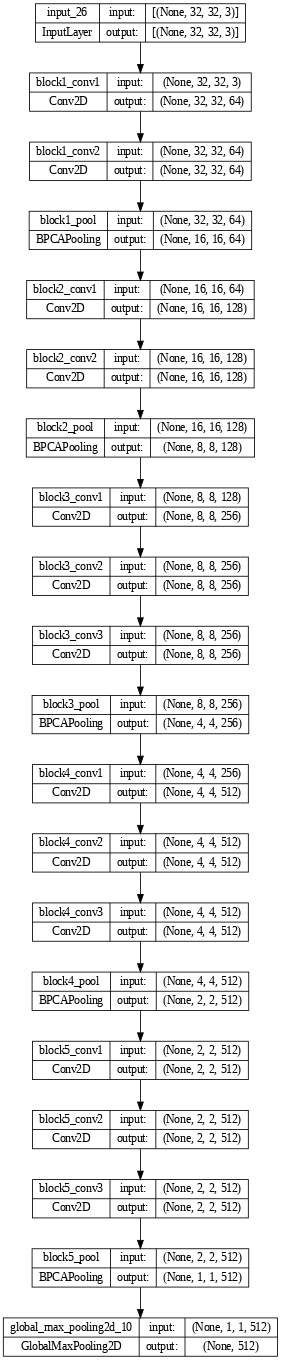

In [106]:
tf.keras.utils.plot_model(vgg16_model, expand_nested=True, dpi=60, show_shapes=True)

In [107]:
model = Sequential()
model.add(vgg16_model)
# model.add(layers.Flatten(name="flatten"))
model.add(layers.Dense(4096, activation="relu", name="fc1"))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(4096, activation="relu", name="fc2"))
model.add(layers.Dense(len(labels), activation='softmax', name="predictions"))

untrainable_layers = [0]
for idx, layer in enumerate(model.layers):
    print(idx, layer)
    layer.trainable = False
    if idx not in untrainable_layers:
        layer.trainable = True

model.summary()
vgg16_model = model
del model


0 <keras.engine.functional.Functional object at 0x7f2c6148aec0>
1 <keras.layers.core.dense.Dense object at 0x7f2c945e7f70>
2 <keras.layers.regularization.dropout.Dropout object at 0x7f2c945e6920>
3 <keras.layers.core.dense.Dense object at 0x7f2d80ee2860>
4 <keras.layers.core.dense.Dense object at 0x7f2d24212c80>
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 fc1 (Dense)                 (None, 4096)              2101248   
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 pre

# Training

In [108]:
model_checkpointer = ModelCheckpoint(
    f'cifar100_vgg16_bpca_warmup.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

optimizer = Adam(learning_rate=1e-5)

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

start_time = time.perf_counter()
history = vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
    validation_data=(X_valid, y_valid),
    epochs=1,
    verbose=1,
    callbacks=[
        model_checkpointer
    ]
)
end_time = time.perf_counter()


391/391 [==============================] - ETA: 0s - loss: 4.6278 - accuracy: 0.0133
Epoch 1: val_accuracy improved from -inf to 0.01900, saving model to cifar100_vgg16_bpca_warmup.h5
391/391 [==============================] - 155s 377ms/step - loss: 4.6278 - accuracy: 0.0133 - val_loss: 4.5839 - val_accuracy: 0.0190


In [109]:
print(f"Elapsed time {end_time-start_time}")

Elapsed time 155.68262042800052
